In [1]:
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from datetime import datetime

In [2]:
import seaborn as sns

In [3]:
# DATA IS FROM https://www.kaggle.com/austinreese/craigslist-carstrucks-data version 8. 
vehicles = pd.read_csv('../Raw Data/vehicles_v8.csv',parse_dates=True)

<AxesSubplot:>

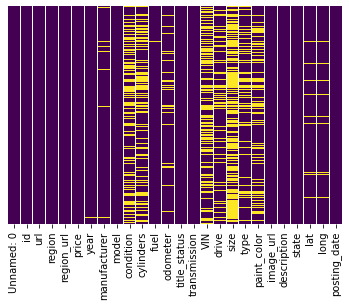

In [4]:
# CHECK FOR MISSING DATA:
sns.heatmap(vehicles.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [5]:
pd.set_option('display.max_columns', None)
vehicles.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,NaN,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,NaN,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


In [6]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

In [7]:
# ROMOVE IRRELEVANT COLUMNS AND COLUMNS MISSING TOO MUCH DATA
vehicles_trimmed = vehicles.drop(['Unnamed: 0','id','url','region_url',
                          'VIN','size','image_url','description'],
                         axis=1)
# REMOVE CARS PRE-1984 SO THE DATA BASE MATCHES THE RANGE OF THE EPA DATABASE
vehicles_trimmed = vehicles_trimmed[vehicles_trimmed['year'] >= 1984]

In [8]:
# DROP THE REMAINING ROWS WITH MISSING VALUES FOR SELECTED COLUMNS THAT ARE NOT MISSING A LOT OF DATA
col_keep = {'condition', 'cylinders', 'odometer','drive', 'type','paint_color'}
col_all = set(vehicles_trimmed.columns)
col_subset_remove_nan = col_all - col_keep
print(f" The following columns had rows with 'nan' values dropped: \n{col_subset_remove_nan}")

vehicles_trimmed.dropna(subset= col_subset_remove_nan, inplace=True)

 The following columns had rows with 'nan' values dropped: 
{'fuel', 'lat', 'manufacturer', 'region', 'price', 'year', 'model', 'posting_date', 'transmission', 'state', 'title_status', 'long'}


In [9]:
vehicles_trimmed = vehicles_trimmed.astype('string')
vehicles_trimmed['cylinders'] = vehicles_trimmed['cylinders'].str.extract('(\d+)', expand = False)
vehicles_trimmed['cylinders'] = vehicles_trimmed['cylinders'].astype(float)
vehicles_trimmed['price'] = vehicles_trimmed['price'].astype(float)
vehicles_trimmed['year'] = pd.to_numeric(vehicles_trimmed['year']).astype(int)
vehicles_trimmed['odometer'] = pd.to_numeric(vehicles_trimmed['odometer'])
vehicles_trimmed['lat'] = pd.to_numeric(vehicles_trimmed['lat'])
vehicles_trimmed['long'] = pd.to_numeric(vehicles_trimmed['long'])
vehicles_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416577 entries, 0 to 458211
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        416577 non-null  string 
 1   price         416577 non-null  float64
 2   year          416577 non-null  int32  
 3   manufacturer  416577 non-null  string 
 4   model         416577 non-null  string 
 5   condition     246730 non-null  string 
 6   cylinders     262836 non-null  float64
 7   fuel          416577 non-null  string 
 8   odometer      371234 non-null  float64
 9   title_status  416577 non-null  string 
 10  transmission  416577 non-null  string 
 11  drive         298809 non-null  string 
 12  type          318342 non-null  string 
 13  paint_color   290644 non-null  string 
 14  state         416577 non-null  string 
 15  lat           416577 non-null  float64
 16  long          416577 non-null  float64
 17  posting_date  416577 non-null  string 
dtypes: f

In [10]:
vehicles_trimmed['drive'].unique()

<StringArray>
['rwd', 'fwd', <NA>, '4wd']
Length: 4, dtype: string

In [11]:
# CREATING A COLUMN TO MATCH THE "drive" TO WHAT IS IN THE EPA SPREADSHEET
vehicles_trimmed['drive_simple'] = vehicles_trimmed['drive']
vehicles_trimmed['drive_simple'] = vehicles_trimmed['drive_simple'].fillna('')

vehicles_trimmed['drive_simple'].loc[
    (vehicles_trimmed['drive_simple'] == 'fwd') | 
    (vehicles_trimmed['drive_simple'] == 'rwd')] = '2wd'

In [12]:
# CREATING A COLUMN TO MATCH THE "model" COLUMN TO WHAT IS IN THE EPA SPREADSHEET
vehicles_trimmed['model_epa'] = vehicles_trimmed['model'] + ' ' + vehicles_trimmed['drive_simple']

In [13]:
vehicles_trimmed['year_make_model'] = (vehicles_trimmed['year'].astype('Int32').map(str)+' '+
                                       vehicles_trimmed['manufacturer']+' '+
                                       vehicles_trimmed['model']+ " "+
                                       vehicles_trimmed['drive_simple']+ " "+
                                       vehicles_trimmed['transmission']+ " "+ 
                                       vehicles_trimmed['fuel'])
                                        


In [14]:
vehicles_trimmed['year_make_model']

0         2010 chevrolet corvette grand sport 2wd other gas
1                     2014 hyundai sonata 2wd automatic gas
2                           2006 bmw x3 3.0i  automatic gas
4                2005 ford f350 lariat 4wd automatic diesel
5              2016 toyota tacoma double cab sr5  other gas
                                ...                        
458207    2017 audi a4 premium plus quattro awd  automat...
458208                  2014 cadillac srx 4wd automatic gas
458209                2018 hyundai tucson 4wd automatic gas
458210        2014 cadillac cts coupe awd 4wd automatic gas
458211           2008 jeep grand cherokee 4wd automatic gas
Name: year_make_model, Length: 416577, dtype: string

In [15]:
# CONCATENATE A year_make_model COLUMN TO RELATE TO THE epa_vehicles spreadsheet
vehicles_trimmed['year_make_model'] = (vehicles_trimmed['year'].astype('Int32').map(str)+' '+
                                       vehicles_trimmed['manufacturer']+' '+
                                       vehicles_trimmed['model']+ " "+
                                       vehicles_trimmed['drive_simple']+ " "+
                                       vehicles_trimmed['transmission']+ " "+ 
                                       vehicles_trimmed['fuel'])

# CONVERT THE year_make_model COLUMN TO A STRING TYPE
vehicles_trimmed['year_make_model'] = vehicles_trimmed['year_make_model'].astype('string')
# REMOVE ANY "nan" IN THE STRING
vehicles_trimmed['year_make_model'] = vehicles_trimmed['year_make_model'].str.replace(' nan ',' ')


vehicles_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416577 entries, 0 to 458211
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   region           416577 non-null  string 
 1   price            416577 non-null  float64
 2   year             416577 non-null  int32  
 3   manufacturer     416577 non-null  string 
 4   model            416577 non-null  string 
 5   condition        246730 non-null  string 
 6   cylinders        262836 non-null  float64
 7   fuel             416577 non-null  string 
 8   odometer         371234 non-null  float64
 9   title_status     416577 non-null  string 
 10  transmission     416577 non-null  string 
 11  drive            298809 non-null  string 
 12  type             318342 non-null  string 
 13  paint_color      290644 non-null  string 
 14  state            416577 non-null  string 
 15  lat              416577 non-null  float64
 16  long             416577 non-null  floa

In [16]:
vehicles_trimmed.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,drive_simple,model_epa,year_make_model
0,auburn,35990.0,2010,chevrolet,corvette grand sport,good,8.0,gas,32742.0,clean,other,rwd,other,<NA>,al,32.590000,-85.480000,2020-12-02T08:11:30-0600,2wd,corvette grand sport 2wd,2010 chevrolet corvette grand sport 2wd other gas
1,auburn,7500.0,2014,hyundai,sonata,excellent,4.0,gas,93600.0,clean,automatic,fwd,sedan,<NA>,al,32.547500,-85.468200,2020-12-02T02:11:50-0600,2wd,sonata 2wd,2014 hyundai sonata 2wd automatic gas
2,auburn,4900.0,2006,bmw,x3 3.0i,good,6.0,gas,87046.0,clean,automatic,<NA>,SUV,blue,al,32.616807,-85.464149,2020-12-01T19:50:41-0600,,x3 3.0i,2006 bmw x3 3.0i automatic gas
4,auburn,19500.0,2005,ford,f350 lariat,excellent,8.0,diesel,116000.0,lien,automatic,4wd,pickup,blue,al,32.547500,-85.468200,2020-12-01T12:53:56-0600,4wd,f350 lariat 4wd,2005 ford f350 lariat 4wd automatic diesel
5,auburn,29590.0,2016,toyota,tacoma double cab sr5,good,6.0,gas,33290.0,clean,other,<NA>,pickup,red,al,32.590000,-85.480000,2020-12-01T07:27:25-0600,,tacoma double cab sr5,2016 toyota tacoma double cab sr5 other gas


<AxesSubplot:>

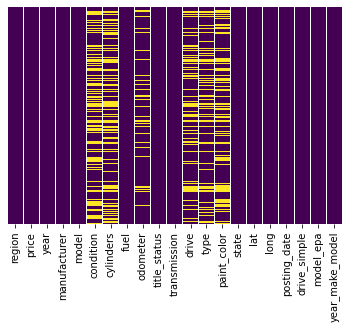

In [17]:
# CHECKING FOR MISSING VALUES AFTER TRIMMING DATA
# SOME COLUMNS ARE KEPT WITH MISSING DATA THAT CAN BE FILLED IN (VIA THE EPA TABLE OR REGRESSION), 
# OR MAY BE USEFUL FOR ANALYZING THE SMALLER SUBSET WHERE IT IS NOT NULL
sns.heatmap(vehicles_trimmed.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [18]:
# DATA FROM https://www.fueleconomy.gov/feg/ws/index.shtml
# THIS DATA WILL BE USED TO FILL IN MISSING CYLINDERS, DRIVE, SIZE, AND TYPE VALUES
epa_vehicles = pd.read_csv('../Raw Data/EPA_Cars_1984-2022.csv')


C:\Users\George\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<AxesSubplot:>

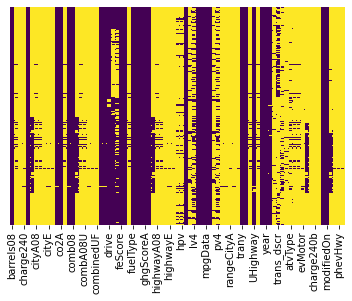

In [19]:
# SET ALL 0 VALUES TO NULL
epa_vehicles = epa_vehicles.replace([float(0), int(0)], np.nan)
# CHECK FOR MISSING DATA:
sns.heatmap(epa_vehicles.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [20]:
# COMPARING vehicles_trimmed FUEL TYPES TO epa_vehicles FUEL TYPES
vehicles_trimmed['fuel'].unique()

<StringArray>
['gas', 'diesel', 'other', 'hybrid', 'electric']
Length: 5, dtype: string

In [21]:
# COMPARING epa_vehicles_trimmed FUEL TYPES TO vehicles_trimmed PRIMARY FUEL TYPES
epa_vehicles['fuelType1'].unique()

array(['Regular Gasoline', 'Premium Gasoline', 'Diesel', 'Natural Gas',
       'Electricity', 'Midgrade Gasoline'], dtype=object)

In [22]:
# COMPARING vehicles_trimmed FUEL TYPES TO epa_vehicles SECONDARY FUEL TYPES
epa_vehicles['fuelType2'].unique()

array([nan, 'Natural Gas', 'E85', 'Propane', 'Electricity'], dtype=object)

In [23]:
# REPLACE FUEL TYPES IN epa_vehicles TO MATCH WHAT IS IN THE vehicles_trimmed DATAFRAME

# REPLACE VARIOUS TYPES OF 'GASSOLINE' WITH 'GAS'
epa_vehicles['fuelType1'] = epa_vehicles['fuelType1'].replace(
    ['Regular Gasoline', 'Premium Gasoline','Midgrade Gasoline'], 'gas')
# REPLACE DIESEL, NATURAL GAS, AND ELECTRICITY WITH THE vehicles_trimmed EQUIVALENT
epa_vehicles['fuelType1'] = epa_vehicles['fuelType1'].replace(
    ['Diesel', 'Natural Gas','Electricity'], 
    ['diesel', 'other', 'electric'])
# IF THE SECONDARY FUEL IS ELECTRICTY, SET FUEL TYPE TO 'hybrid'
epa_vehicles.loc[epa_vehicles['fuelType2'] == 'Electricity', 'fuelType1'] = 'hybrid'
# IF THE SECONDARY FUEL IS NATURAL GAS, SET FUEL TYPE TO 'other'
epa_vehicles.loc[epa_vehicles['fuelType2'] == 'Natural Gas', 'fuelType1'] = 'other'
# IF THE SECONDARY FUEL IS PROPANE, SET FUEL TYPE TO 'other'
epa_vehicles.loc[epa_vehicles['fuelType2'] == 'Propane', 'fuelType1'] = 'other'

# RETURN UNIQUE fuelType1 VALUES FROM THE ipa_vehicles DATAFRAME FRO INSPECTION
epa_vehicles['fuelType1'].unique()

array(['gas', 'diesel', 'other', 'electric', 'hybrid'], dtype=object)

In [24]:
# SPLIT THE "trany" COLUMN AND SELECT THE FIRST ENTRY SO IT MATCHES THE vehicles_trimmed DATA FRAME
epa_vehicles['trany'] = epa_vehicles['trany'].str.split(' ').str[0]
# CHANGE "year" FROM FLOAT TO INT
epa_vehicles['year'] = epa_vehicles['year'].astype(int)
#epa_vehicles.head(5)

In [25]:
# SET "year" TO INT TYPE
epa_vehicles['year'] = epa_vehicles['year'].astype(int)

# CONCATENATE YEAR, MAKE, AND MODEL FOR LOOKUP WITH VEHICLES TABLE
epa_vehicles['year_make_model'] = (epa_vehicles['year'].map(str) +" "+ 
                                   epa_vehicles['make'].map(str) +" "+ 
                                   epa_vehicles['model'].map(str) +" "+ 
                                   epa_vehicles['trany'].map(str) +" "+ 
                                   epa_vehicles['fuelType1'].map(str))
# CHANGE THE year_make_model COLUMN FROM OBJECT TYPE TO A STRING TYPE
epa_vehicles['year_make_model'] = epa_vehicles['year_make_model'].astype('string')
# CHANGE TO LOWER CASE TO MATCH THE vehicles DF
epa_vehicles['year_make_model'] = epa_vehicles['year_make_model'].str.lower()

In [26]:
# CREATE A SET OF THE ORIGINAL COLUMN NAMES TO SEE WHICH COLUMNS WERE REMOVED
epa_vehicles_org_cols = set(epa_vehicles.columns)
# DROP COLUMNS WITH MOSTLY MISSING DATA
epa_vehicles_trimmed = epa_vehicles.dropna(axis = 1, thresh = 40000)
# DROP CREATED ON AND MODIFIED ON COLUMNS
epa_vehicles_trimmed = epa_vehicles_trimmed.drop(['createdOn','modifiedOn'], axis = 1)
# CREATE A SET OF THE CURRENT COLUMN NAMES TO SEE WHICH COLUMNS WERE REMOVED
epa_vehicles_trimmed_cols = set(epa_vehicles_trimmed.columns)
# COLUMNS REMOVED:
#epa_vehicles_org_cols - epa_vehicles_trimmed_cols
epa_vehicles_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43359 entries, 0 to 43358
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   barrels08        43359 non-null  float64
 1   city08           43359 non-null  float64
 2   co2              43088 non-null  float64
 3   co2A             43359 non-null  float64
 4   co2TailpipeGpm   43088 non-null  float64
 5   comb08           43359 non-null  float64
 6   cylinders        43085 non-null  float64
 7   displ            43086 non-null  float64
 8   drive            42173 non-null  object 
 9   feScore          43359 non-null  float64
 10  fuelCost08       43359 non-null  float64
 11  fuelType         43359 non-null  object 
 12  fuelType1        43359 non-null  object 
 13  ghgScore         43359 non-null  float64
 14  ghgScoreA        43347 non-null  float64
 15  highway08        43359 non-null  float64
 16  id               43359 non-null  float64
 17  make        

<AxesSubplot:>

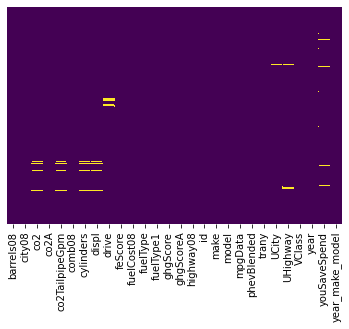

In [27]:
# CHECK FOR MISSING DATA:
sns.heatmap(epa_vehicles_trimmed.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [28]:
for col in epa_vehicles_trimmed.columns:
    if epa_vehicles_trimmed[col].dtype == 'object':
        epa_vehicles_trimmed[col] = epa_vehicles_trimmed[col].astype('string').str.lower()
        

epa_vehicles_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43359 entries, 0 to 43358
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   barrels08        43359 non-null  float64
 1   city08           43359 non-null  float64
 2   co2              43088 non-null  float64
 3   co2A             43359 non-null  float64
 4   co2TailpipeGpm   43088 non-null  float64
 5   comb08           43359 non-null  float64
 6   cylinders        43085 non-null  float64
 7   displ            43086 non-null  float64
 8   drive            42173 non-null  string 
 9   feScore          43359 non-null  float64
 10  fuelCost08       43359 non-null  float64
 11  fuelType         43359 non-null  string 
 12  fuelType1        43359 non-null  string 
 13  ghgScore         43359 non-null  float64
 14  ghgScoreA        43347 non-null  float64
 15  highway08        43359 non-null  float64
 16  id               43359 non-null  float64
 17  make        

In [29]:
epa_vehicles_trimmed.head()

,barrels08,city08,co2,co2A,co2TailpipeGpm,comb08,cylinders,displ,drive,feScore,fuelCost08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,id,make,model,mpgData,phevBlended,trany,UCity,UHighway,VClass,year,youSaveSpend,year_make_model
0,15.695714,19.0,-1.0,-1.0,423.190476,21.0,4.0,2.0,rear-wheel drive,-1.0,1950.0,regular,gas,-1.0,-1.0,25.0,1.0,alfa romeo,spider veloce 2000,y,False,manual,23.3333,35.0000,two seaters,1985,-2250.0,1985 alfa romeo spider veloce 2000 manual gas
1,29.964545,9.0,-1.0,-1.0,807.909091,11.0,12.0,4.9,rear-wheel drive,-1.0,3700.0,regular,gas,-1.0,-1.0,14.0,10.0,ferrari,testarossa,n,False,manual,11.0000,19.0000,two seaters,1985,-11000.0,1985 ferrari testarossa manual gas
2,12.207778,23.0,-1.0,-1.0,329.148148,27.0,4.0,2.2,front-wheel drive,-1.0,1500.0,regular,gas,-1.0,-1.0,33.0,100.0,dodge,charger,y,False,manual,29.0000,47.0000,subcompact cars,1985,NaN,1985 dodge charger manual gas
3,29.964545,10.0,-1.0,-1.0,807.909091,11.0,8.0,5.2,rear-wheel drive,-1.0,3700.0,regular,gas,-1.0,-1.0,12.0,1000.0,dodge,b150/b250 wagon 2wd,n,False,automatic,12.2222,16.6667,vans,1985,-11000.0,1985 dodge b150/b250 wagon 2wd automatic gas
4,17.347895,17.0,-1.0,-1.0,467.736842,19.0,4.0,2.2,4-wheel or all-wheel drive,-1.0,2650.0,premium,gas,-1.0,-1.0,23.0,10000.0,subaru,legacy awd turbo,n,False,manual,21.0000,32.0000,compact cars,1993,-5750.0,1993 subaru legacy awd turbo manual gas


In [30]:
# REMAINING ROWS
epa_vehicles_trimmed['year_make_model'].count()

43359

In [31]:
# CHECK FOR duplicate DATA in year_make_model:
#sns.heatmap(epa_vehicles_trimmed.isnull(),yticklabels=False,cbar=False,cmap='viridis')
epa_vehicles['year_make_model'].nunique()

28911

In [32]:
epa_vehicles_trimmed.head()

,barrels08,city08,co2,co2A,co2TailpipeGpm,comb08,cylinders,displ,drive,feScore,fuelCost08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,id,make,model,mpgData,phevBlended,trany,UCity,UHighway,VClass,year,youSaveSpend,year_make_model
0,15.695714,19.0,-1.0,-1.0,423.190476,21.0,4.0,2.0,rear-wheel drive,-1.0,1950.0,regular,gas,-1.0,-1.0,25.0,1.0,alfa romeo,spider veloce 2000,y,False,manual,23.3333,35.0000,two seaters,1985,-2250.0,1985 alfa romeo spider veloce 2000 manual gas
1,29.964545,9.0,-1.0,-1.0,807.909091,11.0,12.0,4.9,rear-wheel drive,-1.0,3700.0,regular,gas,-1.0,-1.0,14.0,10.0,ferrari,testarossa,n,False,manual,11.0000,19.0000,two seaters,1985,-11000.0,1985 ferrari testarossa manual gas
2,12.207778,23.0,-1.0,-1.0,329.148148,27.0,4.0,2.2,front-wheel drive,-1.0,1500.0,regular,gas,-1.0,-1.0,33.0,100.0,dodge,charger,y,False,manual,29.0000,47.0000,subcompact cars,1985,NaN,1985 dodge charger manual gas
3,29.964545,10.0,-1.0,-1.0,807.909091,11.0,8.0,5.2,rear-wheel drive,-1.0,3700.0,regular,gas,-1.0,-1.0,12.0,1000.0,dodge,b150/b250 wagon 2wd,n,False,automatic,12.2222,16.6667,vans,1985,-11000.0,1985 dodge b150/b250 wagon 2wd automatic gas
4,17.347895,17.0,-1.0,-1.0,467.736842,19.0,4.0,2.2,4-wheel or all-wheel drive,-1.0,2650.0,premium,gas,-1.0,-1.0,23.0,10000.0,subaru,legacy awd turbo,n,False,manual,21.0000,32.0000,compact cars,1993,-5750.0,1993 subaru legacy awd turbo manual gas


In [33]:
# CREATE A DATAFRAME WITH ONLY UNIQUE ELEMENTS OF THE year_make_model COLUMN
epa_vehicles_trimmed_unique = epa_vehicles_trimmed.drop_duplicates(subset = ['year_make_model'])
# CHECK TO MAKE SURE THE COUNT OF THIS COLUMN IS AS EXPECTED
epa_vehicles_trimmed_unique['year_make_model'].count()

28911

In [34]:
# ALL MAKERS FROM CRAIGSLIST
craigslist_make = vehicles_trimmed['manufacturer'].unique()
# ALL MAKERS FROM EPA
epa_make = epa_vehicles_trimmed_unique['make'].str.lower().unique()

# ITTERATE THROUGH MAKERS IN BOTH LISTS AND SHOW MISS-MATCHES ALONG WITH THEIR MOST LIKELY MATCH
for manuf in craigslist_make:
    match = False
    for make in epa_make:
        if manuf == make:
            match = True
            break
    if match == False:
        possible_matches = process.extract(manuf, epa_make, limit=2)
        print(f"craigslist {manuf}:".ljust(30)  + 
              f"{possible_matches}".ljust(50) + 
              f"n={vehicles_trimmed['manufacturer'].loc[vehicles_trimmed['manufacturer'] == manuf].count()}")
        #print(f"No Match! craigslist {manuf} has no epa equivalent")

craigslist rover:             [('land rover', 90), ('vector', 55)]              n=1341
craigslist alfa-romeo:        [('alfa romeo', 100), ('geo', 60)]                n=173
craigslist harley-davidson:   [('byd', 60), ('azure dynamics', 55)]             n=112
craigslist aston-martin:      [('aston martin', 100), ('smart', 72)]            n=34
craigslist datsun:            [('daihatsu', 71), ('saturn', 67)]                n=2


In [35]:
# DROP harley-davidson AND datsun (THERE ARE NOT MANY AND THEY DO NOT CORRELATE WITH MAKERS IN epa_vehicles)
vehicles_trimmed = vehicles_trimmed.loc[
    (vehicles_trimmed['manufacturer'] != 'harley-davidson') & 
    (vehicles_trimmed['manufacturer'] != 'datsun')]

In [36]:
# CONVERT ALL CLOSELY MATCHED vehicles_trimmed['manufacturer'] TO MATCH THE epa_vehicles VALUE

# ALL MAKERS FROM CRAIGSLIST
craigslist_make = vehicles_trimmed['manufacturer'].unique()
# ALL MAKERS FROM EPA
epa_make = epa_vehicles_trimmed_unique['make'].str.lower().unique()

# ITTERATE THROUGH MAKERS IN BOTH LISTS AND SHOW MISS-MATCHES ALONG WITH THEIR MOST LIKELY MATCH
for manuf in craigslist_make:
    match = False
    for make in epa_make:
        if manuf == make:
            match = True
            break
    if match == False:
        possible_matches = process.extract(manuf, epa_make, limit=1)
        for match in possible_matches:
            if match[1] > 85:
                vehicles_trimmed['manufacturer'].loc[vehicles_trimmed['manufacturer'] == manuf] = match[0]

In [37]:
# MATCH THE DATA FRAMES

# AFTER THINKING ABOUT IT AND DOING A BIT OF RESEARCH, RUNNING FUZZYWUZZY TO MATCH OVER 20,000 COLUMNS IS A BIT MUCH.
# A BETTER APPROACH IS TO BREAK THE DATA INTO CHUNKS BASED ON YEAR AND MAKER (SINCE THESE WILL MATCH ACROSS DATA FRAMES)
    # AND THEN MATCH AFTER THAT. 

In [38]:
for i in epa_vehicles_trimmed_unique['model'].loc[epa_vehicles_trimmed_unique['make'] == 'ford'].unique():
    print(i)

taurus
taurus sho
thunderbird
e150 club wagon
ltd crown victoria
escort wagon
taurus wagon
f150 pickup 2wd
f250 pickup 2wd
ranger pickup 2wd
f150 pickup 4wd
ranger pickup 4wd
aerostar van
aerostar van awd
e150 econoline 2wd
e250 econoline 2wd
aerostar wagon
aerostar wagon awd
explorer 2wd
bronco 4wd
explorer 4wd
aspire
mustang
probe
escort
tempo
bronco ii 4wd
crown victoria police
lightning f150 2wd
ranger pickup cab chassis
contour
taurus ffv
exp
crown victoria
laser
windstar fwd van
windstar fwd wagon
crown victoria cng
f250
ltd
f250 pickup 4wd
expedition 2wd
expedition 4wd
escort zx2
f250 pickup 2wd cng
ltd wagon
e250 econoline 2wd cng
ranger 2wd ffv
ranger 4wd ffv
focus
focus station wagon
lightning pickup 2wd
postal vehicle
windstar fwd cargo van
f150 pickup 2wd cng
explorer sport trac 2wd
explorer sport trac 4wd
escape 2wd
explorer sport 2wd
explorer usps 2wd
escape 4wd
explorer sport 4wd
explorer usps 4wd
f150 cng
e250 cng
taurus wagon ffv
explorer usps 4wd ffv
f150 dual-fuel 2w

In [39]:
epa_vehicles_trimmed_unique[
    (epa_vehicles_trimmed_unique['fuelType1'].str.lower() == 'diesel') & 
    (epa_vehicles_trimmed_unique['year'] == 2021)
    ]

,barrels08,city08,co2,co2A,co2TailpipeGpm,comb08,cylinders,displ,drive,feScore,fuelCost08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,id,make,model,mpgData,phevBlended,trany,UCity,UHighway,VClass,year,youSaveSpend,year_make_model
35933,15.924375,22.0,412.0,-1.0,412.0,24.0,6.0,3.0,4-wheel drive,5.0,1900.0,diesel,diesel,4.0,-1.0,28.0,42691.0,land rover,range rover,n,False,automatic,27.9000,NaN,standard sport utility vehicle 4wd,2021,-2000.0,2021 land rover range rover automatic diesel
35934,15.924375,22.0,412.0,-1.0,412.0,24.0,6.0,3.0,4-wheel drive,5.0,1900.0,diesel,diesel,4.0,-1.0,28.0,42692.0,land rover,range rover sport,n,False,automatic,27.9000,NaN,standard sport utility vehicle 4wd,2021,-2000.0,2021 land rover range rover sport automatic di...
35990,17.372045,19.0,455.0,-1.0,455.0,22.0,4.0,2.8,4-wheel drive,4.0,2100.0,diesel,diesel,4.0,-1.0,28.0,42749.0,chevrolet,colorado 4wd,n,False,automatic,24.2000,39.7000,small pickup trucks 4wd,2021,-3000.0,2021 chevrolet colorado 4wd automatic diesel
35992,20.115000,18.0,525.0,-1.0,525.0,19.0,4.0,2.8,4-wheel drive,3.0,2400.0,diesel,diesel,3.0,-1.0,22.0,42750.0,chevrolet,colorado zr2 4wd,n,False,automatic,21.1000,31.2493,small pickup trucks 4wd,2021,-4500.0,2021 chevrolet colorado zr2 4wd automatic diesel
35993,17.372045,19.0,455.0,-1.0,455.0,22.0,4.0,2.8,4-wheel drive,4.0,2100.0,diesel,diesel,4.0,-1.0,28.0,42751.0,gmc,canyon 4wd,n,False,automatic,24.2000,39.7000,small pickup trucks 4wd,2021,-3000.0,2021 gmc canyon 4wd automatic diesel
36058,16.616739,20.0,435.0,-1.0,435.0,23.0,4.0,2.8,rear-wheel drive,5.0,2000.0,diesel,diesel,4.0,-1.0,30.0,42811.0,chevrolet,colorado 2wd,n,False,automatic,25.2000,42.4000,small pickup trucks 2wd,2021,-2500.0,2021 chevrolet colorado 2wd automatic diesel
36059,16.616739,20.0,435.0,-1.0,435.0,23.0,4.0,2.8,rear-wheel drive,5.0,2000.0,diesel,diesel,4.0,-1.0,30.0,42812.0,gmc,canyon 2wd,n,False,automatic,25.2000,42.4000,small pickup trucks 2wd,2021,-2500.0,2021 gmc canyon 2wd automatic diesel
36228,15.287400,22.0,411.0,-1.0,411.0,25.0,6.0,3.0,4-wheel drive,5.0,1850.0,diesel,diesel,4.0,-1.0,29.0,42965.0,jeep,wrangler 4dr ecodiesel 4wd,n,False,automatic,28.1996,41.2000,small sport utility vehicle 4wd,2021,-1750.0,2021 jeep wrangler 4dr ecodiesel 4wd automatic...
36229,16.616739,21.0,442.0,-1.0,442.0,23.0,6.0,3.0,4-wheel drive,5.0,2000.0,diesel,diesel,4.0,-1.0,26.0,42966.0,jeep,wrangler rubic 4dr ecodiesel 4wd,y,False,automatic,28.1996,41.2000,small sport utility vehicle 4wd,2021,-2500.0,2021 jeep wrangler rubic 4dr ecodiesel 4wd aut...
36276,14.699423,22.0,390.0,-1.0,390.0,26.0,6.0,3.0,rear-wheel drive,5.0,1750.0,diesel,diesel,5.0,-1.0,32.0,43007.0,ram,1500 2wd,n,False,automatic,28.7000,NaN,standard pickup trucks 2wd,2021,-1250.0,2021 ram 1500 2wd automatic diesel


In [55]:
years = range(2020,2021)
data_year = []
data_manuf = []
data_fuel = []
data_trany = []
data_model = []
data_match_model = []
data_match_score = []
vehicles_trimmed['epa_matched_model'] = np.nan
row_counter = 0

for year in years:
    manufacturers = vehicles_trimmed['manufacturer'].loc[vehicles_trimmed['year'] == year].unique()
    epa_manufacturers = epa_vehicles_trimmed_unique['make'].loc[epa_vehicles_trimmed_unique['year'] == year].unique()
    for manuf in manufacturers:
        fuels = vehicles_trimmed['fuel'].loc[
            (vehicles_trimmed['year'] == year) & 
            (vehicles_trimmed['manufacturer'] == manuf)].unique()
        epa_fuels = epa_vehicles_trimmed_unique['fuelType1'].loc[
            (epa_vehicles_trimmed_unique['year'] == year) & 
            (epa_vehicles_trimmed_unique['make'] == manuf)].unique()
        for fuel in fuels:
            transmissions = vehicles_trimmed['transmission'].loc[
                (vehicles_trimmed['year'] == year) & 
                (vehicles_trimmed['manufacturer'] == manuf) & 
                (vehicles_trimmed['fuel'] == fuel)].unique()
            epa_transmissions = epa_vehicles_trimmed_unique['trany'].loc[
                (epa_vehicles_trimmed_unique['year'] == year) & 
                (epa_vehicles_trimmed_unique['make'] == manuf) & 
                (epa_vehicles_trimmed_unique['fuelType1'] == fuel)].unique()
            for trany in transmissions:
                models = vehicles_trimmed['model_epa'].loc[
                    (vehicles_trimmed['year'] == year) & 
                    (vehicles_trimmed['manufacturer'] == manuf) & 
                    (vehicles_trimmed['fuel'] == fuel) &
                    (vehicles_trimmed['transmission'] == trany)].unique()
                    
                epa_models = epa_vehicles_trimmed_unique['model'].loc[
                    (epa_vehicles_trimmed_unique['year'] == year) & 
                    (epa_vehicles_trimmed_unique['make'] == manuf) & 
                    (epa_vehicles_trimmed_unique['fuelType1'] == fuel) &
                    (epa_vehicles_trimmed_unique['trany'] == trany)].unique()
                    
                for model in models:
                    matches = process.extract(model, epa_models,scorer=fuzz.token_set_ratio,limit = 1)
                    print(f"{row_counter} {year} {manuf} {fuel} {trany} {model}: {matches}")
                    data_year.append(year)
                    data_manuf.append(manuf)
                    data_fuel.append(fuel)
                    data_trany.append(trany)
                    data_model.append(model)
                    

                    if len(matches) == 0:
                        epa_match_model = np.nan
                        epa_match_score = np.nan
                        
                        data_match_model.append(np.nan)
                        data_match_score.append(np.nan)
                        
                    elif len(matches) > 0:
                        epa_match_model = matches[0][0]
                        epa_match_score = matches[0][1]
                        
                        data_match_model.append(epa_match_model)
                        data_match_score.append(epa_match_score)
                    
                  
                    row_counter += 1


                    if epa_match_score != np.nan and epa_match_score > 0:
                        vehicles_trimmed.loc[
                        (vehicles_trimmed['year'] == year) & 
                        (vehicles_trimmed['manufacturer'] == manuf) & 
                        (vehicles_trimmed['fuel'] == fuel) &
                        (vehicles_trimmed['transmission'] == trany) & 
                        (vehicles_trimmed['model'] == model), 'epa_matched_model'] = "Test"

                    
data = {'year': data_year, 'manuf':data_manuf,'fuel':data_fuel,'trany':data_trany,'model':data_model, 'epa_model_match': data_match_model,'match_score': data_match_score}

0 2020 jeep gas automatic gladiator 4wd: [('gladiator pickup 4wd', 100)]
1 2020 jeep gas automatic wrangler unlimited sport s 4wd: [('wrangler 4wd', 100)]
2 2020 jeep gas automatic grand cherokee 4wd: [('cherokee 4wd', 100)]
3 2020 jeep gas automatic compass 4wd: [('compass 4wd', 100)]
4 2020 jeep gas automatic grand cherokee summit 4x4 4wd: [('cherokee 4wd', 100)]
5 2020 jeep gas automatic cherokee 4wd: [('cherokee 4wd', 100)]
6 2020 jeep gas automatic gladiator gladiator sport leveled 4wd: [('gladiator pickup 4wd', 79)]
7 2020 jeep gas automatic gladiator overland pickup 4wd: [('gladiator pickup 4wd', 100)]
8 2020 jeep gas automatic gladiator sport 4wd: [('gladiator pickup 4wd', 81)]
9 2020 jeep gas automatic wrangler : [('wrangler 4wd', 100)]
10 2020 jeep gas automatic wrangler unlimited 4wd: [('wrangler 4wd', 100)]
11 2020 jeep gas automatic gladiator sport s automatic 4wd: [('gladiator pickup 4wd', 79)]
12 2020 jeep gas automatic gladiator sport s 4wd: [('gladiator pickup 4wd', 79

115 2020 gmc gas automatic yukon 2wd: [('yukon c1500 2wd', 100)]
116 2020 gmc gas automatic sierra 1500 slt 4wd : [('sierra 4wd', 100)]
117 2020 gmc gas automatic terrain 4wd: [('terrain fwd', 91)]
118 2020 gmc gas automatic terrain slt automatic 4wd: [('terrain fwd', 78)]
119 2020 gmc gas automatic sierra 1500 4wd: [('sierra 4wd', 100)]
120 2020 gmc gas automatic sierra 1500 denali automatic 4wd: [('sierra 4wd', 100)]
121 2020 gmc gas automatic acadia 4wd: [('acadia fwd', 90)]
122 2020 gmc gas automatic sierra 1500 sle 2wd: [('sierra 2wd', 100)]
123 2020 gmc gas automatic sierra 1500 sle : [('sierra 2wd', 75)]
124 2020 gmc gas automatic yukon xl slt sport utility : [('yukon c1500 xl 2wd', 62)]
125 2020 gmc gas automatic sierra 1500 elevation automatic 4wd: [('sierra 4wd', 100)]
126 2020 gmc gas automatic terrain sle : [('terrain fwd', 78)]
127 2020 gmc gas automatic sierra 2500hd 4wd: [('sierra 4wd', 100)]
128 2020 gmc gas automatic yukon denali 2wd: [('yukon c1500 2wd', 75)]
129 2020

244 2020 toyota gas automatic corolla 2wd: [('corolla', 100)]
245 2020 toyota gas automatic corolla hybrid le sedan 2wd: [('corolla', 100)]
246 2020 toyota gas automatic camry 2wd: [('camry', 100)]
247 2020 toyota gas automatic 4runner trd offrd premium : [('4runner 2wd', 78)]
248 2020 toyota gas automatic camry : [('camry', 100)]
249 2020 toyota gas automatic corolla xle automatic 2wd: [('corolla', 100)]
250 2020 toyota gas automatic camry se 2wd: [('camry', 100)]
251 2020 toyota gas automatic corolla le automatic 2wd: [('corolla', 100)]
252 2020 toyota gas automatic highlander 4wd: [('highlander', 100)]
253 2020 toyota gas automatic tacoma 4wd: [('tacoma 4wd', 100)]
254 2020 toyota gas automatic 4runner : [('4runner 2wd', 100)]
255 2020 toyota gas automatic sienna base le : [('sienna 2wd', 75)]
256 2020 toyota gas automatic corolla hatchback xse 4d 2wd: [('corolla', 100)]
257 2020 toyota gas automatic highlander hybrid : [('highlander', 100)]
258 2020 toyota gas automatic corolla hyb

379 2020 toyota gas manual corolla hatchback se 4d 2wd: [('corolla', 100)]
380 2020 toyota gas manual corolla 2wd: [('corolla', 100)]
381 2020 toyota gas manual tacoma sr5 4wd: [('tacoma 4wd', 100)]
382 2020 toyota gas manual tacoma 4wd 4wd: [('tacoma 4wd', 100)]
383 2020 toyota gas manual corolla le 2wd: [('corolla', 100)]
384 2020 toyota gas manual sequoia 4wd: [('tacoma 4wd', 57)]
385 2020 toyota gas manual tacoma 4wd: [('tacoma 4wd', 100)]
386 2020 toyota gas manual corolla se 2wd: [('corolla', 100)]
387 2020 toyota gas manual corolla se manual 2wd: [('corolla', 100)]
388 2020 toyota gas manual tacoma trd off road 4wd: [('tacoma 4wd', 100)]
389 2020 toyota gas other gr supra 3.0 premium 2wd: []
390 2020 toyota gas other gr supra 3.0 coupe 2d 2wd: []
391 2020 toyota gas other corolla le 2wd: []
392 2020 toyota gas other camry 2wd: []
393 2020 toyota diesel automatic sprinter passenger 2500 : []
394 2020 toyota other other tacoma trd off road doubl : []
395 2020 toyota other automati

526 2020 nissan gas other rogue : []
527 2020 nissan gas other maxima : []
528 2020 nissan gas other maxima 4wd: []
529 2020 nissan gas other altima 2wd: []
530 2020 nissan gas other altima 2.5 sr 2wd: []
531 2020 nissan other automatic maxima sv : []
532 2020 nissan other automatic rogue 4wd: []
533 2020 nissan other automatic altima 2.5 sr 2wd: []
534 2020 nissan other automatic versa sr sedan 4d 2wd: []
535 2020 nissan other automatic pathfinder sv 2wd: []
536 2020 nissan other other murano : []
537 2020 nissan other other altima 2wd: []
538 2020 nissan other other maxima : []
539 2020 ram gas automatic 1500 classic crew cab slt 4wd: [('1500 4wd', 100)]
540 2020 ram gas automatic 1500 big horn 4wd 4x4 : [('1500 4wd', 100)]
541 2020 ram gas automatic 1500 tradesman : [('1500 2wd', 67)]
542 2020 ram gas automatic 1500 classic 4wd: [('1500 4wd', 100)]
543 2020 ram gas automatic 1500 4wd: [('1500 4wd', 100)]
544 2020 ram gas automatic 1500 slt : [('1500 2wd', 67)]
545 2020 ram gas autom

702 2020 chevrolet gas automatic 2500 express ls 2wd: [('tahoe c1500 2wd', 53)]
703 2020 chevrolet gas automatic spark : [('spark', 100)]
704 2020 chevrolet gas automatic blazer : [('blazer fwd', 100)]
705 2020 chevrolet gas automatic trax 2wd: [('trax fwd', 88)]
706 2020 chevrolet gas automatic suburban lt sport 4wd: [('suburban k1500 4wd', 80)]
707 2020 chevrolet gas automatic tahoe lt sport utility 4wd: [('tahoe k1500 4wd', 75)]
708 2020 chevrolet gas automatic silverado 1500 regular : [('silverado 2wd', 82)]
709 2020 chevrolet gas automatic silverado 2500 : [('silverado 2wd', 82)]
710 2020 chevrolet gas automatic silverado 1500 : [('silverado 2wd', 82)]
711 2020 chevrolet gas automatic silverado 2500hd : [('silverado 2wd', 83)]
712 2020 chevrolet gas automatic spark 2wd: [('spark', 100)]
713 2020 chevrolet gas automatic trax lt sport utility 2wd: [('trax fwd', 67)]
714 2020 chevrolet gas automatic equinox lt 2wd: [('equinox fwd', 80)]
715 2020 chevrolet gas automatic malibu : [('ma

858 2020 chevrolet gas other equinox 4wd: []
859 2020 chevrolet gas other colorado 4wd: []
860 2020 chevrolet gas other corvette 2wd: []
861 2020 chevrolet gas other express 2500 : []
862 2020 chevrolet gas other silverado 1500 : []
863 2020 chevrolet gas other c8 corvette : []
864 2020 chevrolet gas other corvette c8 2wd: []
865 2020 chevrolet gas other silverado 1500 lt : []
866 2020 chevrolet gas other equinox lt : []
867 2020 chevrolet gas other traverse lt leather : []
868 2020 chevrolet gas other silverado 1500 custom : []
869 2020 chevrolet gas other c8 corvette 2wd: []
870 2020 chevrolet gas other camaro 2wd: []
871 2020 chevrolet gas manual camaro 2wd: [('camaro', 100)]
872 2020 chevrolet gas manual spark 2wd: [('spark', 100)]
873 2020 chevrolet gas manual silverado 1500 4wd: [('spark activ', 21)]
874 2020 chevrolet gas manual camaro : [('camaro', 100)]
875 2020 chevrolet gas manual traverse 4wd: [('spark activ', 26)]
876 2020 chevrolet gas manual malibu 2wd: [('camaro', 25)]


1136 2020 ford gas automatic f-150 xlt 4x4 4dr super crew 1-owner truck 4wd: [('ranger 4wd', 46)]
1137 2020 ford gas automatic f-150 king ranch 4wd: [('f150 pickup 4wd ffv', 62)]
1138 2020 ford gas automatic transit connect 2wd: [('transit connect van 2wd', 100)]
1139 2020 ford gas automatic transit connect pass. van 2wd: [('transit connect van 2wd', 100)]
1140 2020 ford gas automatic f550 : [('f150 pickup 2wd', 32)]
1141 2020 ford gas automatic escape sel awd : [('escape awd', 100)]
1142 2020 ford gas automatic ecosport s suv 2wd: [('ecosport fwd', 80)]
1143 2020 ford gas automatic transit 350 cargo van 4wd: [('transit t150 wagon 4wd ffv', 75)]
1144 2020 ford gas automatic transit t250 cargo van 2wd: [('transit connect van 2wd', 79)]
1145 2020 ford gas automatic f550 4x4sd 4wd: [('f150 pickup 4wd', 48)]
1146 2020 ford gas automatic f150 supercrew : [('f150 pickup 2wd', 48)]
1147 2020 ford gas automatic f150 raptor 4wd: [('f150 raptor 4wd', 100)]
1148 2020 ford gas automatic escape se 

1272 2020 dodge diesel automatic 2500 big horn 4wd: []
1273 2020 dodge other automatic journey : []
1274 2020 tesla electric automatic mod 3 2wd: [('model 3 mid range', 54)]
1275 2020 tesla electric automatic model 3 4wd: [('model 3 long range', 78)]
1276 2020 tesla electric automatic model y : [('model y performance awd', 100)]
1277 2020 tesla electric automatic x : [('model x long range', 100)]
1278 2020 tesla electric automatic model 3 awd : [('model 3 long range awd', 100)]
1279 2020 tesla electric automatic model 3 : [('model 3 long range', 100)]
1280 2020 tesla electric automatic y performance : [('model y performance awd', 100)]
1281 2020 tesla electric automatic model s 4wd: [('model s long range', 78)]
1282 2020 tesla electric automatic model x 4wd: [('model x long range', 78)]
1283 2020 tesla electric automatic 3 4wd: [('model 3 long range', 33)]
1284 2020 tesla electric automatic model 3 2wd: [('model 3 long range', 78)]
1285 2020 tesla electric other model 3 : []
1286 2020 

1391 2020 honda hybrid other crv exl hybrid 4wd: []
1392 2020 honda hybrid automatic accord hybrid touring 2wd: [('clarity plug-in hybrid', 55)]
1393 2020 honda hybrid automatic accord hybrid 2wd: [('clarity plug-in hybrid', 52)]
1394 2020 honda hybrid automatic insight 2wd: [('clarity plug-in hybrid', 30)]
1395 2020 honda hybrid automatic accord hybrid : [('clarity plug-in hybrid', 63)]
1396 2020 honda gas automatic civic 2wd: [('civic 2dr', 89)]
1397 2020 honda gas automatic pilot ex-l awd 4wd: [('pilot awd', 100)]
1398 2020 honda gas automatic accord : [('accord 2.0t sport/touring', 100)]
1399 2020 honda gas automatic accord sport sedan 2wd: [('accord', 100)]
1400 2020 honda gas automatic civic lx 2wd: [('civic 2dr', 76)]
1401 2020 honda gas automatic accord ex-l 2wd: [('accord', 100)]
1402 2020 honda gas automatic cr-v 2wd: [('cr-v fwd', 88)]
1403 2020 honda gas automatic accord hybrid sedan 4d 2wd: [('accord', 100)]
1404 2020 honda gas automatic civic sport touring 2wd: [('accord 

1565 2020 kia other other forte fe 2wd: []
1566 2020 kia other other rio s 2wd: []
1567 2020 kia other automatic sorento s : []
1568 2020 kia other automatic optima lx 2wd: []
1569 2020 kia other automatic sportage lx : []
1570 2020 kia other automatic forte lxs 2wd: []
1571 2020 kia hybrid automatic niro lx hybrid 2wd: [('niro plug-in hybrid', 76)]
1572 2020 kia hybrid automatic niro lx 2wd: [('niro plug-in hybrid', 53)]
1573 2020 kia hybrid automatic optima plug-in hybrid : [('optima plug-in hybrid', 100)]
1574 2020 infiniti gas automatic qx60 4wd: [('qx60 fwd', 88)]
1575 2020 infiniti gas automatic qx60 luxe : [('qx60 fwd', 67)]
1576 2020 infiniti gas automatic q60 red sport 400 coupe 2wd: [('q60', 100)]
1577 2020 infiniti gas automatic q50 2wd: [('q50', 100)]
1578 2020 infiniti gas automatic qx60 2wd: [('qx60 fwd', 88)]
1579 2020 infiniti gas automatic q60 3.0t luxe coupe 2d 2wd: [('q60', 100)]
1580 2020 infiniti gas automatic qx80 : [('qx80 2wd', 100)]
1581 2020 infiniti gas autom

1702 2020 mercedes-benz hybrid automatic amg gt 53 4wd: [('glc350e 4matic', 30)]
1703 2020 mercedes-benz diesel automatic sprinter cargo van 4wd: []
1704 2020 mercedes-benz diesel automatic sprinter passenger 2wd: []
1705 2020 mercedes-benz diesel automatic sprinter cargo van 2wd: []
1706 2020 mercedes-benz diesel automatic sprinter crew van 2wd: []
1707 2020 mercedes-benz diesel automatic sprinter 3500 2wd: []
1708 2020 mercedes-benz diesel automatic benz sprinter 3500xd 2wd: []
1709 2020 mercedes-benz diesel automatic sprinter 2500 crew : []
1710 2020 mercedes-benz diesel automatic sprinter 4wd: []
1711 2020 mercedes-benz diesel automatic sprinter 2500 carg : []
1712 2020 mercedes-benz diesel automatic sprinter 3500xd 2wd: []
1713 2020 mercedes-benz diesel automatic sprinter cargo 2wd: []
1714 2020 mercedes-benz diesel automatic sprinter cargo 4wd: []
1715 2020 mercedes-benz diesel automatic sprinter 2500 : []
1716 2020 mercedes-benz other automatic gle 350 4matic : []
1717 2020 suba

1842 2020 buick other automatic enclave premium group : []
1843 2020 buick other automatic encore : []
1844 2020 buick other automatic encore 2wd: []
1845 2020 buick other automatic enclave essence 2wd: []
1846 2020 bmw gas automatic x3 4wd: [('x3 m', 67)]
1847 2020 bmw gas automatic 5 series 2wd: [('m235i xdrive', 50)]
1848 2020 bmw gas automatic 330i : [('330i', 100)]
1849 2020 bmw gas automatic x4 : [('x4 m', 100)]
1850 2020 bmw gas automatic 300i : [('330i', 75)]
1851 2020 bmw gas automatic x2 sdrive28i sport utility 2wd: [('x2 sdrive28i', 100)]
1852 2020 bmw gas automatic x3 sdrive30i sport utility 2wd: [('x3 sdrive30i', 100)]
1853 2020 bmw gas automatic x5 2wd: [('x5 m', 67)]
1854 2020 bmw gas automatic x3 2wd: [('x3 m', 67)]
1855 2020 bmw gas automatic x1 2wd: [('x1 xdrive28i', 50)]
1856 2020 bmw gas automatic x1 : [('x1 xdrive28i', 100)]
1857 2020 bmw gas automatic 330i 2wd: [('330i', 100)]
1858 2020 bmw gas automatic x1 sdrive28i sport utility 2wd: [('x1 sdrive28i', 100)]
1859

1970 2020 fiat gas automatic 124 spider 2wd: [('124 spider', 100)]
1971 2020 alfa romeo gas automatic romeo giulia : [('giulia', 100)]
1972 2020 ferrari gas manual 488 pista spider : []


In [69]:
CL_test2020 = vehicles_trimmed[(vehicles_trimmed['year'] == 2020)]
EPA_test2020 = epa_vehicles_trimmed_unique[epa_vehicles_trimmed_unique['year'] == 2020]

In [ ]:
#sns.heatmap(vehicles_trimmed[vehicles_trimmed['year']==2020].isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [78]:
df = pd.DataFrame(data)
df['EPA_equivalent_year_make_model'] = (df['year'].map(str) + " " +
                         df['manuf'].map(str) + " " +
                         df['epa_model_match'].map(str) + " " +
                         df['trany'].map(str) + " " +
                         df['fuel'].map(str) + " ")
                         
df['CL_equivalent_year_make_model'] = (df['year'].map(str) + " " +
                         df['manuf'].map(str) + " " +
                         df['model'].map(str) + " " +
                         df['trany'].map(str) + " " +
                         df['fuel'].map(str) + " ")



df.head()

,year,manuf,fuel,trany,model,epa_model_match,match_score,EPA_equivalent_year_make_model,CL_equivalent_year_make_model
0,2020,jeep,gas,automatic,gladiator 4wd,gladiator pickup 4wd,100.0,2020 jeep gladiator pickup 4wd automatic gas,2020 jeep gladiator 4wd automatic gas
1,2020,jeep,gas,automatic,wrangler unlimited sport s 4wd,wrangler 4wd,100.0,2020 jeep wrangler 4wd automatic gas,2020 jeep wrangler unlimited sport s 4wd autom...
2,2020,jeep,gas,automatic,grand cherokee 4wd,cherokee 4wd,100.0,2020 jeep cherokee 4wd automatic gas,2020 jeep grand cherokee 4wd automatic gas
3,2020,jeep,gas,automatic,compass 4wd,compass 4wd,100.0,2020 jeep compass 4wd automatic gas,2020 jeep compass 4wd automatic gas
4,2020,jeep,gas,automatic,grand cherokee summit 4x4 4wd,cherokee 4wd,100.0,2020 jeep cherokee 4wd automatic gas,2020 jeep grand cherokee summit 4x4 4wd automa...


In [76]:
CL_test2020.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,drive_simple,model_epa,year_make_model,epa_matched_model
19,auburn,47000.0,2020,jeep,gladiator,like new,6.0,gas,10500.0,clean,automatic,4wd,pickup,grey,al,32.611442,-85.481615,2020-11-23T15:02:02-0600,4wd,gladiator 4wd,2020 jeep gladiator 4wd automatic gas,NaN
27,auburn,34990.0,2020,jeep,wrangler unlimited sport s,good,NaN,gas,17622.0,clean,automatic,4wd,SUV,red,al,32.590000,-85.480000,2020-11-20T07:12:46-0600,4wd,wrangler unlimited sport s 4wd,2020 jeep wrangler unlimited sport s 4wd autom...,NaN
108,birmingham,63200.0,2020,gmc,yukon,excellent,8.0,gas,24305.0,clean,automatic,fwd,SUV,white,al,32.419700,-87.024500,2020-12-02T09:57:39-0600,2wd,yukon 2wd,2020 gmc yukon 2wd automatic gas,NaN
114,birmingham,17900.0,2020,toyota,corolla,<NA>,NaN,gas,40022.0,clean,automatic,fwd,<NA>,white,al,32.922900,-86.545000,2020-12-02T09:22:50-0600,2wd,corolla 2wd,2020 toyota corolla 2wd automatic gas,NaN
120,birmingham,28590.0,2020,nissan,370z coupe 2d,good,6.0,gas,2163.0,clean,automatic,rwd,coupe,white,al,33.520000,-86.790000,2020-12-02T08:37:39-0600,2wd,370z coupe 2d 2wd,2020 nissan 370z coupe 2d 2wd automatic gas,NaN


In [77]:
EPA_test2020.head()

,barrels08,city08,co2,co2A,co2TailpipeGpm,comb08,cylinders,displ,drive,feScore,fuelCost08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,id,make,model,mpgData,phevBlended,trany,UCity,UHighway,VClass,year,youSaveSpend,year_make_model
34311,9.694412,31.0,257.0,-1.0,257.0,34.0,4.0,2.0,front-wheel drive,8.0,1200.0,regular,gas,8.0,-1.0,40.0,41213.0,toyota,corolla,y,False,automatic,41.0000,58.7000,compact cars,2020,1500.0,2020 toyota corolla automatic gas
34312,6.338654,53.0,170.0,-1.0,170.0,52.0,4.0,1.8,front-wheel drive,10.0,800.0,regular,gas,10.0,-1.0,52.0,41214.0,toyota,corolla hybrid,y,False,automatic,78.0640,76.1727,compact cars,2020,3500.0,2020 toyota corolla hybrid automatic gas
34313,10.300313,29.0,277.0,-1.0,277.0,32.0,4.0,2.0,front-wheel drive,7.0,1250.0,regular,gas,7.0,-1.0,36.0,41215.0,toyota,corolla,n,False,manual,37.8991,53.3991,compact cars,2020,1250.0,2020 toyota corolla manual gas
34314,9.694412,31.0,265.0,-1.0,265.0,34.0,4.0,2.0,front-wheel drive,8.0,1200.0,regular,gas,8.0,-1.0,38.0,41216.0,toyota,corolla xse,n,False,automatic,40.5039,56.8023,compact cars,2020,1500.0,2020 toyota corolla xse automatic gas
34317,10.300313,29.0,274.0,-1.0,274.0,32.0,4.0,1.8,front-wheel drive,7.0,1250.0,regular,gas,7.0,-1.0,37.0,41219.0,toyota,corolla xle,n,False,automatic,37.9972,55.0926,compact cars,2020,1250.0,2020 toyota corolla xle automatic gas


In [ ]:
year = 2021
fuel = 'gas'
maker = 'ford'
drive = 'automatic'

test_possible_epa_vehicles2 = (
    epa_vehicles_trimmed_unique['model'].loc[(epa_vehicles_trimmed_unique['year'] == year) & 
    (epa_vehicles_trimmed_unique['make'].str.lower() == maker) & 
    (epa_vehicles_trimmed_unique['trany'].str.lower() == drive) &
    (epa_vehicles_trimmed_unique['fuelType1'].str.lower() == fuel)]
    )
test_possible_epa_vehicles2

In [ ]:
test_actual_vehicles2 = (
    vehicles_trimmed['model_epa'].loc[(vehicles_trimmed['year'] == year) & 
    (vehicles_trimmed['manufacturer'] == maker) & 
    (vehicles_trimmed['transmission'].str.lower() == drive) &
    (vehicles_trimmed['fuel'] == fuel)]
    )
test_actual_vehicles2

In [ ]:
for model in test_actual_vehicles2:
    matches = process.extract(model, test_possible_epa_vehicles2,scorer=fuzz.token_set_ratio,limit = 1)
    print(f"{model}: {matches}")